<a href="https://colab.research.google.com/github/benihime91/retinanet_pet_detector/blob/master/notebooks/05_resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Google Drive:**

In [1]:
# Run this cell to mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGgJsnESOqVGM_Kfy-q02g6-qzR1zgWRgARsLuK4eYPmNAP4E7W1Lo
Mounted at /content/gdrive


**setup**

In [2]:
# What GPU do we have ?
! nvidia-smi

Wed Sep  9 02:04:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

In [4]:
# install dependencies
! pip install pytorch-lightning wandb --quiet
! pip install git+https://github.com/albumentations-team/albumentations --quiet

     |████████████████████████████████| 409kB 8.1MB/s 
     |████████████████████████████████| 1.4MB 21.6MB/s 
     |████████████████████████████████| 829kB 55.3MB/s 
     |████████████████████████████████| 276kB 52.4MB/s 
     |████████████████████████████████| 2.8MB 51.3MB/s 
     |████████████████████████████████| 122kB 50.8MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 163kB 59.2MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
     |████████████████████████████████| 952kB 8.2MB/s 


**Before running this cell make sure that the data is present in `GoogleDrive` at `Data/oxford-iiit-pet.tgz` .  
The Data can be downloaded at [here](https://www.robots.ox.ac.uk/~vgg/data/pets/).  
Running this cell will extract the data and save it to the `/content/oxford-iiit-pet` .**

In [5]:
# unzip the data assuming the `The Oxford-IIIT Pet Dataset` is present as /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz
# to download the dataset go to this link:
# https://www.robots.ox.ac.uk/~vgg/data/pets/
! tar xf /content/gdrive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/ 

**Clone the retinanet repo:**

In [6]:
# Clone the RetinaNet Repo:
! git clone https://github.com/benihime91/pytorch_retinanet.git

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 1583 (delta 102), reused 66 (delta 28), pack-reused 1407
Receiving objects: 100% (1583/1583), 51.13 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (1053/1053), done.


In [ ]:
%%bash
cd /content/pytorch_retinanet
git pull

**Instantiate wandb :**  
**If using `wandb` to track logs uncomment the cell and run it.**

In [7]:
# use wandb to track experiments : Comment this if not using wandb logger
! wanbd login # a74f67fd5fae293e301ea8b6710ee0241f595a63

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: a74f67fd5fae293e301ea8b6710ee0241f595a63
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


**required imports:**

In [8]:
import warnings
import os
import sys
from typing import *
import time
import argparse

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PyTorch Imports
import torch
from torch import nn
from torch.optim import *
from torch.utils.data import Dataset, DataLoader

# Lightning import
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (EarlyStopping, ModelCheckpoint, LearningRateLogger,)

# Import some usefull utilities from the RetinaNet Repo:
from pytorch_retinanet.src.models import Retinanet
from pytorch_retinanet.src.utils.coco_utils import CocoEvaluator
from pytorch_retinanet.src.utils.coco_utils import get_coco_api_from_dataset
from pytorch_retinanet.src.utils.general_utils import collate_fn, xml_to_csv
from pytorch_retinanet import DetectionDataset, Visualizer

pl.seed_everything(42) # change this seed number to get different results
pd.set_option("display.max_colwidth", None)

**Preprocess the data:** 

In [10]:
annot_dir = '/content/oxford-iiit-pet/annotations/xmls' # folder where the annotations are stored
img_dir = '/content/oxford-iiit-pet/images' # folder where the training Images are stored

# Create pandas DataFrame from the xmls
df = xml_to_csv(annot_dir)
df.head(5)

filename  width  height  ... ymin  xmax  ymax
0  american_pit_bull_terrier_117.jpg    300     199  ...   17   248   189
1                        pug_181.jpg    209     300  ...   64   199   191
2                     Birman_163.jpg    500     334  ...   45   312   264
3                 Maine_Coon_126.jpg    379     500  ...   10   300   271
4              saint_bernard_122.jpg    500     334  ...   14   374   261

[5 rows x 8 columns]

In [11]:
# regex to extract the class names from the filenames of the csv file
pat = r"/([^/]+)_\d+.jpg$"
pat = re.compile(pat)


def get_classes(df : pd.DataFrame) -> pd.DataFrame:
    "creates labels for the Images from given filenames"
    # Extract the label
    df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]
    return df


def preprare_data(img_dir: str, data: Union[str, pd.DataFrame]) -> Union[pd.DataFrame, LabelEncoder]:
    "preprocess the given data and returns a pandas dataframe"
    if isinstance(data, str):
        df = pd.read_csv(data)
    else:
        df = data
    # modify filename to point to the image path
    df["filename"] = [os.path.join(img_dir, idx) for idx in df.filename.values]
    # get labels from the filename
    df = get_classes(df)
    # encode the labels: convert labels to integers
    le = LabelEncoder()
    int_cls = le.fit(df["class"].unique())
    df["labels"] = le.transform(df["class"])
    return df, le


def create_label_dict(dataframe: pd.DataFrame, encoder: LabelEncoder) -> Dict[int, str]:
    "Creates a label dictionary from the given dataframe `labels`"
    names = list(dataframe.labels.unique())
    names.sort()
    # Create the label dictionary
    label_dict = {idx: clas for idx, clas in zip(
        names, list(encoder.inverse_transform(names)))}
    return label_dict


In [12]:
df , le = preprare_data(img_dir, df)
df.head()

filename  ...  labels
0  /content/oxford-iiit-pet/images/american_pit_bull_terrier_117.jpg  ...       2
1                        /content/oxford-iiit-pet/images/pug_181.jpg  ...      25
2                     /content/oxford-iiit-pet/images/Birman_163.jpg  ...       6
3                 /content/oxford-iiit-pet/images/Maine_Coon_126.jpg  ...      20
4              /content/oxford-iiit-pet/images/saint_bernard_122.jpg  ...      28

[5 rows x 9 columns]

In [13]:
# Grab the label dictionary
label_dict = create_label_dict(df, le)
label_dict

{0: 'abyssinian',
 1: 'american_bulldog',
 2: 'american_pit_bull_terrier',
 3: 'basset_hound',
 4: 'beagle',
 5: 'bengal',
 6: 'birman',
 7: 'bombay',
 8: 'boxer',
 9: 'british_shorthair',
 10: 'chihuahua',
 11: 'egyptian_mau',
 12: 'english_cocker_spaniel',
 13: 'english_setter',
 14: 'german_shorthaired',
 15: 'great_pyrenees',
 16: 'havanese',
 17: 'japanese_chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'maine_coon',
 21: 'miniature_pinscher',
 22: 'newfoundland',
 23: 'persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'ragdoll',
 27: 'russian_blue',
 28: 'saint_bernard',
 29: 'samoyed',
 30: 'scottish_terrier',
 31: 'shiba_inu',
 32: 'siamese',
 33: 'sphynx',
 34: 'staffordshire_bull_terrier',
 35: 'wheaten_terrier',
 36: 'yorkshire_terrier'}

**utility function to display image with bounding boxes:**

In [14]:
# Instantiate the visualizer
viz = Visualizer(class_names=label_dict)

# Function to display a random Image from the dataset
def display_random_image(dataframe: pd.DataFrame, **kwargs) -> None:
    "displays a radom Image from given dataframe"
    n = np.random.randint(0, len(dataframe))
    fname = df["filename"][n]
    boxes = df.loc[df["filename"] == fname][["xmin", "ymin", "xmax", "ymax"]].values
    labels = df.loc[df["filename"] == fname]["labels"].values
    viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10, 10), **kwargs)

**Display image from the data:**

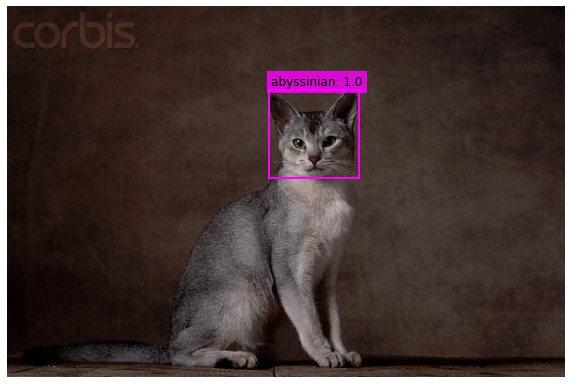

In [15]:
# Display some random Images from the Dataset for sanity check
display_random_image(df)

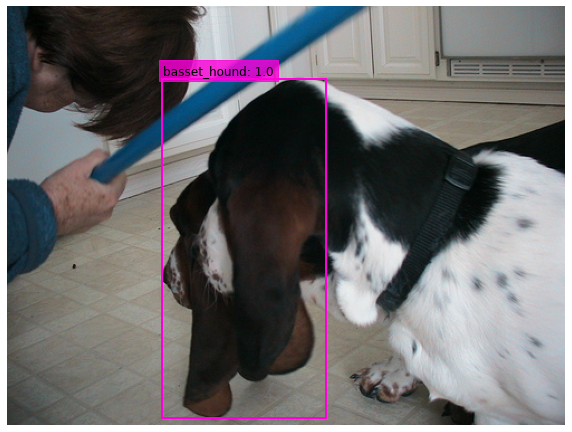

In [16]:
display_random_image(df)

In [18]:
# Helper function to split a given DataFrame
def create_splits(df: pd.DataFrame, split_sz: float = 0.3) -> Tuple[pd.DataFrame, pd.DataFrame]:
    "Split given DataFrame into `split_sz`"
    
    # Grab the Unique Image Idxs from the Filename
    unique_ids = list(df.filename.unique())
    # Split the Unique Image Idxs into Train & valid Datasets
    train_ids, val_ids = train_test_split(
        unique_ids, shuffle=True, random_state=42, test_size=split_sz
    )

    # Create Splits on the DataFrame
    df["split"] = 0

    for i, idx in enumerate(df.filename.values):
        if idx in set(train_ids):
            df["split"][i] = "train"
        elif idx in set(val_ids):
            df["split"][i] = "val"

    # Split the DataFrame into Train and Valid DataFrames
    df_trn, df_val = df.loc[df["split"] == "train"], df.loc[df["split"] == "val"]

    df_trn, df_val = df_trn.reset_index(drop=True), df_val.reset_index(drop=True)

    # drop the extra redundent column
    df_trn.drop(columns=["split"], inplace=True)
    df_val.drop(columns=["split"], inplace=True)

    return df_trn, df_val

**Create spilts in the DataFrame to get `train`, `validation` & `test` sets**:

In [19]:
# Create train and validation splits from the dataframe
df_trn, df_val = create_splits(df, split_sz=0.3)
df_val, df_test = create_splits(df_val, split_sz=0.5)

print('Num examples in train dataset :', len(df_trn.filename.unique()))
print('Num examples in valid dataset :', len(df_val.filename.unique()))
print('Num examples in test dataset :', len(df_test.filename.unique()))

Num examples in train dataset : 2580
Num examples in valid dataset : 553
Num examples in test dataset : 553


In [20]:
# Peek at the train dataset for sanity check
df_trn.head(3)

filename  width  ...  ymax labels
0         /content/oxford-iiit-pet/images/pug_181.jpg    209  ...   191     25
1      /content/oxford-iiit-pet/images/Birman_163.jpg    500  ...   264      6
2  /content/oxford-iiit-pet/images/Maine_Coon_126.jpg    379  ...   271     20

[3 rows x 9 columns]

In [21]:
# Peek at the validation dataset for sanity check
df_val.head(3)

filename  ...  labels
0          /content/oxford-iiit-pet/images/chihuahua_164.jpg  ...      10
1  /content/oxford-iiit-pet/images/yorkshire_terrier_139.jpg  ...      36
2         /content/oxford-iiit-pet/images/Maine_Coon_112.jpg  ...      20

[3 rows x 9 columns]

In [22]:
df_test.head(3)

filename  ...  labels
0  /content/oxford-iiit-pet/images/american_pit_bull_terrier_117.jpg  ...       2
1                    /content/oxford-iiit-pet/images/Siamese_194.jpg  ...      32
2                        /content/oxford-iiit-pet/images/pug_101.jpg  ...      25

[3 rows x 9 columns]

**sanity check**:

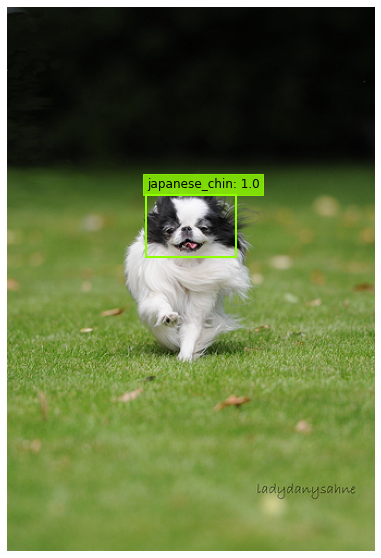

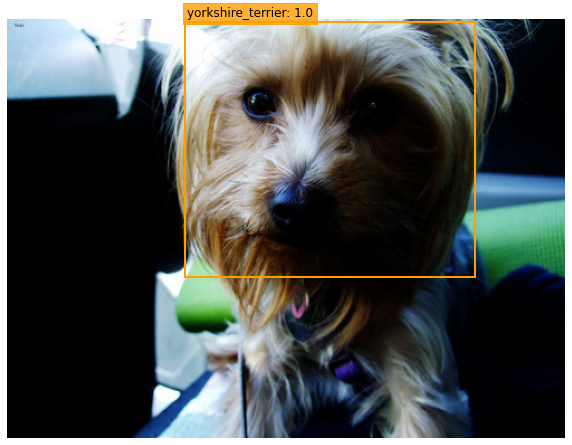

In [23]:
# display random image from the train, valid 
# & test datasets for sanity check
display_random_image(dataframe=df_trn)
display_random_image(dataframe=df_trn)

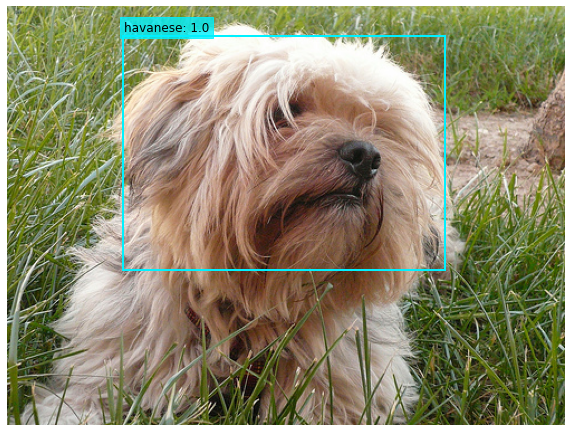

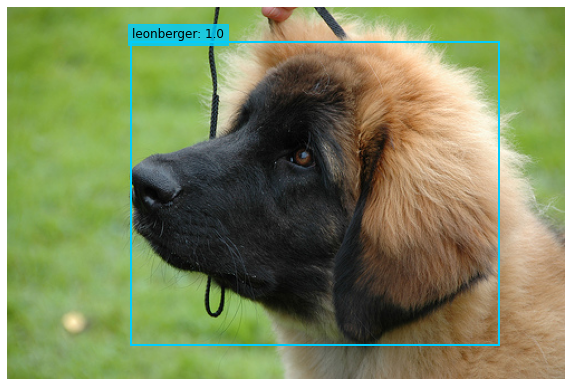

In [24]:
display_random_image(dataframe=df_val)
display_random_image(dataframe=df_val)

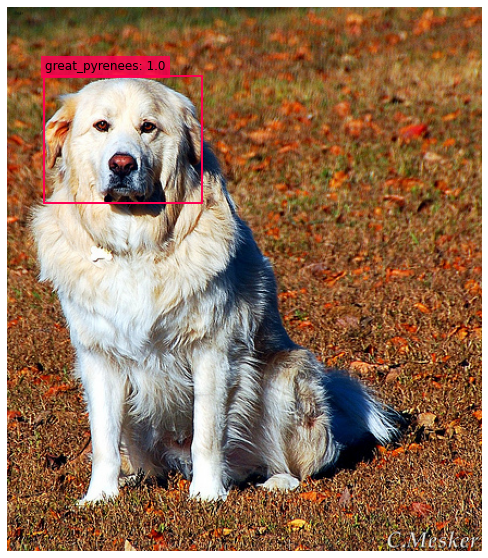

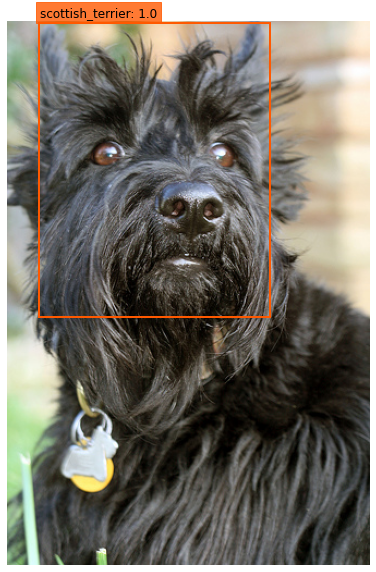

In [25]:
display_random_image(dataframe=df_test)
display_random_image(dataframe=df_test)

In [26]:
# Save the dataframes
df_trn.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)
df_val.to_csv('val.csv',   index=False)

**Instantiate image transformations:**

We use `albumentations` for image transformations. Check [albumentations docs](https://albumentations.ai/docs/examples/example_bboxes/) for API reference & list of transformations

In [27]:
def get_tfms() -> Dict[str, A.Compose]:
    "Returns a dictionary contatining transformations for train & valid/test datasets"
    
    # train transformations : [Modify this to add Transformations to train dataset] 
    trn_tfms = [
        A.HorizontalFlip(p=0.5),
        A.ToGray(p=0.2),
        A.RandomBrightnessContrast(p=0.5),
        A.CLAHE(p=0.5),
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ]

    # validation transformations : [Transformations to the validation dataset]
    val_tfms = [
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ]

    # test transformations : [Transformations to the test dataset]
    tst_tfms = [
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),                
    ]

    # transforms dictionary :
    transforms = {
        "train": A.Compose(trn_tfms, bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]),),
        "valid": A.Compose(val_tfms, bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]),),
        "test" : A.Compose(tst_tfms, bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"]),),
    }
    
    return transforms

**Create `pl.LightningModule` instance :**

In [28]:
# Create pl.LightningModule instance

# ========
# INFO :
# ========
# The hparams config file should contain the following :
# ========
# 1. optimizer : torch.optim.Optimizer -> Optimizer for the model
# 2. scheduler : Union[torch.optim.lr_scheduler, None] -> Scheduler for the Optimizer

# 3. trn_df    : pandas.DataFrame -> train dataframe
# 4. trn_bs    : int -> train batch_size

# 5. val_df    : pandas.DataFrame -> validation dataframe
# 6. val_bs    : int -> validation batch_size

# 7. test_df   :  pandas.DataFrame -> test dataframe
# 8. test_bs   : int -> test batch_size

# 9. iou_types : List -> for coco evaluation set it to ["bbox"].

class DetectionModel(pl.LightningModule):
    def __init__(self, model: nn.Module, hparams: argparse.Namespace) -> None:
        super(DetectionModel, self).__init__()
        self.model = model
        self.hparams = hparams

    @property
    def num_batches(self) -> List:
        "returns a list containing the number of batches in train, val & test dataloaders"
        return [len(self.train_dataloader()), len(self.val_dataloader()), len(self.test_dataloader())]

    ##################################################################
    ############## Configure Optimizer & Schedulers ##################
    ##################################################################
    def configure_optimizers(self, *args, **kwargs):
        "instatiate optimizer & scheduler(s)" 
        # optimizer
        optimizer = self.hparams.optimizer
        # scheduler
        scheduler = self.hparams.scheduler
        
        if scheduler is not None:
            return [optimizer], [scheduler]
        else:
            return [optimizer]

    ##################################################################
    ############# Forward Pass of the Model ##########################
    ##################################################################
    def forward(self, xb, *args, **kwargs):
        "forward step"
        return self.model(xb)

    ##################################################################
    ########################## preprare data #########################
    ##################################################################
    def setup(self, stage=None):
        # Instantiate Transforms:
        self.tfms    = get_tfms()
        # Load in the DataFrames
        self.trn_df  = pd.read_csv(self.hparams.trn_df) # train dataframe
        self.val_df  = pd.read_csv(self.hparams.val_df) # valid dataframe
        self.test_df = pd.read_csv(self.hparams.test_df) # test dataframe

    ##################################################################
    ########################### Trainining ###########################
    ##################################################################
    def train_dataloader(self, *args, **kwargs):
        "instantiate train dataloader" 
        # instantiate the trian dataset
        train_ds = DetectionDataset(self.trn_df, self.tfms['train'])
        # load in the dataloader
        trn_dl = DataLoader(
            train_ds, batch_size=self.hparams.trn_bs, shuffle=True, collate_fn=collate_fn, pin_memory=True,
            )
        
        return trn_dl

    def training_step(self, batch, batch_idx, *args, **kwargs):
        "one training step"
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        return {"loss": losses, "log": loss_dict, "progress_bar": loss_dict}

    ##################################################################
    ###################### Validation ################################
    ##################################################################
    def val_dataloader(self, *args, **kwargs):
        "instatiate validation dataloader"
        # instantiate the validaiton dataset
        val_ds = DetectionDataset(self.val_df, self.tfms['valid'])
        # instantiate dataloader
        loader = DataLoader(val_ds, batch_size=self.hparams.val_bs, shuffle=False, collate_fn=collate_fn,)
        # instantiate coco_api to track metrics
        coco = get_coco_api_from_dataset(loader.dataset)
        self.coco_evaluator = CocoEvaluator(coco, self.hparams.iou_types)
        return loader

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        "one validation step"
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        self.coco_evaluator.update(res)
        return {}

    def validation_epoch_end(self, outputs, *args, **kwargs):
        self.coco_evaluator.accumulate()
        self.coco_evaluator.summarize()
        metric = self.coco_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        logs = {"valid_mAP": metric}
        return {"valid_mAP": metric, "log": logs, "progress_bar": logs,}
    
    ##################################################################
    ######################## Test ####################################
    ##################################################################
    def test_dataloader(self, *args, **kwargs):
        "instatiate validation dataloader"
        # instantiate train dataset
        test_ds = DetectionDataset(self.test_df, self.tfms['test'])
        # instantiate dataloader
        loader = DataLoader(test_ds, batch_size=self.hparams.test_bs, shuffle=False, collate_fn=collate_fn,)
        # instantiate coco_api to track metrics
        coco = get_coco_api_from_dataset(loader.dataset)
        self.test_evaluator = CocoEvaluator(coco, self.hparams.iou_types)
        return loader

    def test_step(self, batch, batch_idx, *args, **kwargs):
        "one test step"
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        self.test_evaluator.update(res)
        return {}
    
    def test_epoch_end(self, outputs, *args, **kwargs):
        self.test_evaluator.accumulate()
        self.test_evaluator.summarize()
        metric = self.test_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        logs = {"test_mAP": metric}
        return {"test_mAP": metric, "log": logs, "progress_bar": logs,}

**Specify Configs: :**

**Configs for `DetectionModel` :**


In [29]:
# ============================================= #
# Specify Patametrs for the DetectionModel:
# ============================================= #

# load in the RetinaNet model
NUM_CLASSES = 37  # Oxford-IIIT Pets Dataset has 37 classes
BACKBONE = 'resnet34' # backbone for RetinaNet Model

# ================================================================================== #
# Instantiate model
model = Retinanet(num_classes=NUM_CLASSES, backbone_kind=BACKBONE)
# =================================================================================== #

# =================================================================================== #
# Train dataset Parametrs:
trn_df = '/content/train.csv' # path 2 dataframe
trn_bs = 32 # batch_size

# Valid dataset parametrs:
val_df = '/content/val.csv' # path 2 dataframe
val_bs = 32 # batch_size

# Test dataset parametrs:
test_df = '/content/test.csv' # path 2 dataframe
test_bs = 32 # batch_size

# Instantiate Optimizer
LR = 1e-03
WEIGHT_DECAY = 0.001
MOMENTUM = 0.9
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
# Instantiate scheduler
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
# convert scheduler to lightning format
INTERVAL = "step" # scheduler interval wether after each 'step' for each 'epoch'
scheduler = {"scheduler": scheduler, "interval": INTERVAL , "frequency": 1,}

# set iou types:
iou_types = ['bbox']
# ===================================================================================== #

# Create arguments:
hparams = {
    'optimizer': optimizer,
    'scheduler': scheduler,
    'trn_df'   : trn_df,
    'trn_bs'   : trn_bs,
    'val_df'   : val_df,
    'val_bs'   : val_bs,
    'test_df'  : test_df,
    'test_bs'  : test_bs,
    'iou_types': iou_types,
}

# Convert dictionary to args
hparams= argparse.Namespace(**hparams)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


**Configs for `LightningTrainer`:**

In [30]:
# ============================================= #
# Create configs for lighntning trainer :
# ============================================= #
EPOCHS = 110 # Total number of Epochs
# ====================================================================== #

# Wandb logger: assuming wandb is set-up [Optional]
wb_name = f"resnet34-||-{time.strftime('%d-%m-||-%I.%M.%S%-p')}" # change the run name here
wb_p = "retinanet-oxford-pets" # change the project name here
wb_logger = WandbLogger(name=wb_name, project=wb_p, anonymous="allow",) # instantiate wandb logger

# learning_rate logger:
lr_logger = LearningRateLogger(logging_interval="step")

# setup callbacks & loggers into a list
# since pl.Trainer expects them to be in a list format
logger=[wb_logger]
callbacks=[lr_logger]

# checkpoint callback will save the top 2 checkpoints
# path to the directory where to save the checkpoints
fname = "/content/pets_resnet34_checkpoints"
os.makedirs(fname, exist_ok=True)
checkpoint_callback = ModelCheckpoint(fname, mode="max", monitor="valid_mAP", save_top_k=2,)

# early stopping callback
early_stop_callback = EarlyStopping(mode="max", monitor="valid_mAP", patience=3,)

check_val_every_n_epoch = 10 # Validaiton Check Interval
gpus = 1  # gpus to use
precision = 16 # precision

# ====================================================================== #


# Convert trainer flags into a dictionary
trainer_config = {
    'num_sanity_val_steps' : 0,
    'benchmark': True, # Set benchmark True to get better performance
    'logger': logger,
    'callbacks': callbacks,
    'checkpoint_callback': checkpoint_callback,
    'early_stop_callback' : early_stop_callback,
    'gpus': gpus,
    'precision': precision,
    'max_epochs': EPOCHS,
    'check_val_every_n_epoch': check_val_every_n_epoch,
}

trainer_config = argparse.Namespace(**trainer_config)

**Grab the model & the trainer:**

In [31]:
# instantiate lightning model
retinanet = DetectionModel(model, hparams)
# instantiate lightning trainer
trainer = pl.Trainer.from_argparse_args(trainer_config)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [32]:
trainer.fit(retinanet)


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 30 M  


creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.844
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.575
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.575
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Saving latest checkpoint..


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

1

**Evaluate:**

In [33]:
# Test model on the Test DataLoader
# NB: Best weights are automatically loaded
trainer.test()

creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

[{'test_mAP': 0.5313118811881188}]

In [38]:
retinanet.model.state_dict().keys()

odict_keys(['backbone.backbone.conv1.weight', 'backbone.backbone.bn1.weight', 'backbone.backbone.bn1.bias', 'backbone.backbone.bn1.running_mean', 'backbone.backbone.bn1.running_var', 'backbone.backbone.bn1.num_batches_tracked', 'backbone.backbone.layer1.0.conv1.weight', 'backbone.backbone.layer1.0.bn1.weight', 'backbone.backbone.layer1.0.bn1.bias', 'backbone.backbone.layer1.0.bn1.running_mean', 'backbone.backbone.layer1.0.bn1.running_var', 'backbone.backbone.layer1.0.bn1.num_batches_tracked', 'backbone.backbone.layer1.0.conv2.weight', 'backbone.backbone.layer1.0.bn2.weight', 'backbone.backbone.layer1.0.bn2.bias', 'backbone.backbone.layer1.0.bn2.running_mean', 'backbone.backbone.layer1.0.bn2.running_var', 'backbone.backbone.layer1.0.bn2.num_batches_tracked', 'backbone.backbone.layer1.1.conv1.weight', 'backbone.backbone.layer1.1.bn1.weight', 'backbone.backbone.layer1.1.bn1.bias', 'backbone.backbone.layer1.1.bn1.running_mean', 'backbone.backbone.layer1.1.bn1.running_var', 'backbone.backbo

**Save trained weights**

In [48]:
fname = '/content/gdrive/My Drive/pets_resnet34/resnet34-pets-ver0.0.1.pth'
torch.save(retinanet.model.state_dict(), f=fname, _use_new_zipfile_serialization=False)

**Inference**: 

**import & helper functions for inference:**

In [41]:
from google.colab import files
from torchvision.ops.boxes import batched_nms

test_tfms = A.Compose([A.ToFloat(max_value=255.0, always_apply=True), ToTensorV2(always_apply=True),])

**Load in a `torch` model to do inference:**  

**Model weights can be loaded in 2 ways either load the weights trained above in that case set fname to be the `path` to where the `state_dict` is saved.**

In [76]:
wf = '/content/gdrive/My Drive/pets_resnet34/resnet34-pets-ver0.0.1.pth'

@torch.no_grad()
def get_preds(path, threshold, iou_threshold, device, fname=wf) -> Tuple[List, List, List]:
    "Get predictions on image"
    print('[INFO] Serializing Model')

    # Instantiate Torch Model for Inference
    model = Retinanet(num_classes=37,backbone_kind='resnet34',score_thres=threshold,nms_thres=iou_threshold,)
    # Load in the pretrained model weights from weights file
    model.load_state_dict(torch.load(fname))
    model.to(device)
    
    # Load the image
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    # Process the image
    img = test_tfms(image=img)["image"]
    img = img.to(device)
    
    print("[INFO] Generating predictions ....")

    # Generate predictions
    model.eval()
    pred = model([img])

    # Gather the bbox, scores & labels from the preds
    pred_boxes = pred[0]["boxes"]  # Bounding boxes
    pred_class = pred[0]["labels"]  # predicted class labels
    pred_score = pred[0]["scores"]  # predicted scores
    
    ## TODO: Fix & make it so that score threshold and nms threshold can be
    # passes directly to the model

    # Get list of index with score greater than threshold.
    mask = pred_score > threshold
    # Filter predictions
    boxes = pred_boxes[mask]
    clas = pred_class[mask]
    scores = pred_score[mask]

    # do NMS
    keep_idxs = batched_nms(boxes, scores, clas, iou_threshold)
    boxes = list(boxes[keep_idxs].cpu().numpy())
    clas = list(clas[keep_idxs].cpu().numpy())
    scores = list(scores[keep_idxs].cpu().numpy())
    return boxes, clas, scores


def object_detection_api(img_path=None, device='cpu', score_threshold = 0.5, iou_threshold = 0.5) -> None:
    "Draw bbox predictions on given image at img_pth"
    
    # if Image path is not Given load image path from the user
    if img_path is None:
        uploaded = files.upload()
        img_path = list(uploaded.keys())[0]

    bb, cls, sc = get_preds(img_path, score_threshold, iou_threshold, device,)
    print("[INFO] Drawing bbox .... ")
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    viz.draw_bboxes(img, boxes=bb, classes=cls, scores=sc)

**inference on test images:**

[INFO] Serializing Model
[INFO] Generating predictions ....
[INFO] Drawing bbox .... 


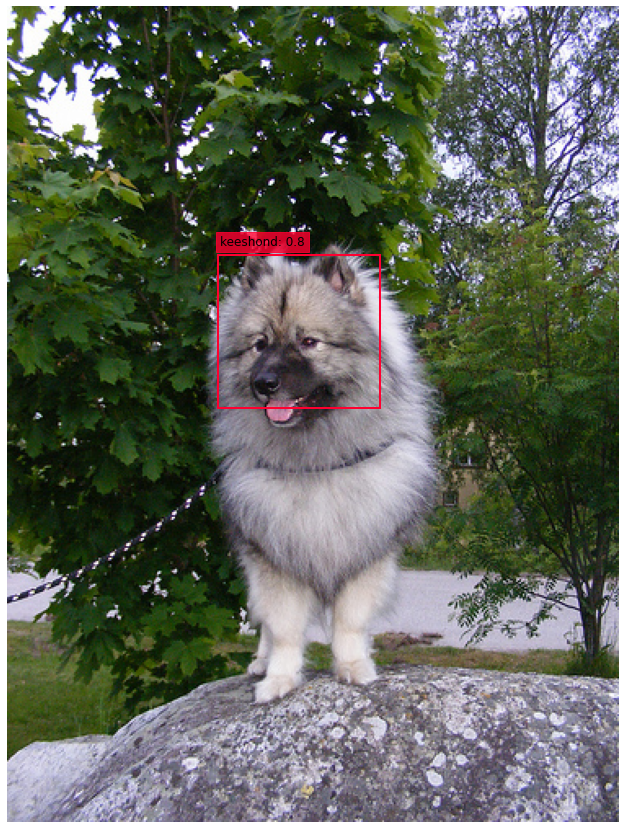

In [71]:
idx = 55 # index of the test_image

object_detection_api(device='cuda:0', score_threshold=0.6, iou_threshold=0.2, img_path=df_test["filename"][idx],)

[INFO] Serializing Model
[INFO] Generating predictions ....
[INFO] Drawing bbox .... 


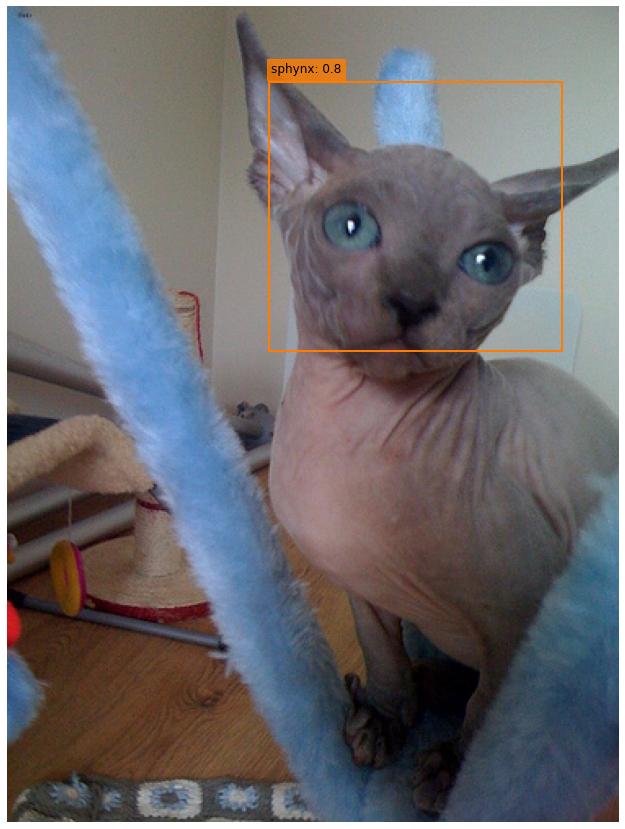

In [77]:
idx = 100 # index of the test_image

object_detection_api(device='cuda:0', score_threshold=0.6, iou_threshold=0.2, img_path=df_test["filename"][idx],)

**inference on user given images:**

Saving random_cat_image.jpeg to random_cat_image (1).jpeg
[INFO] Serializing Model
[INFO] Generating predictions ....
[INFO] Drawing bbox .... 


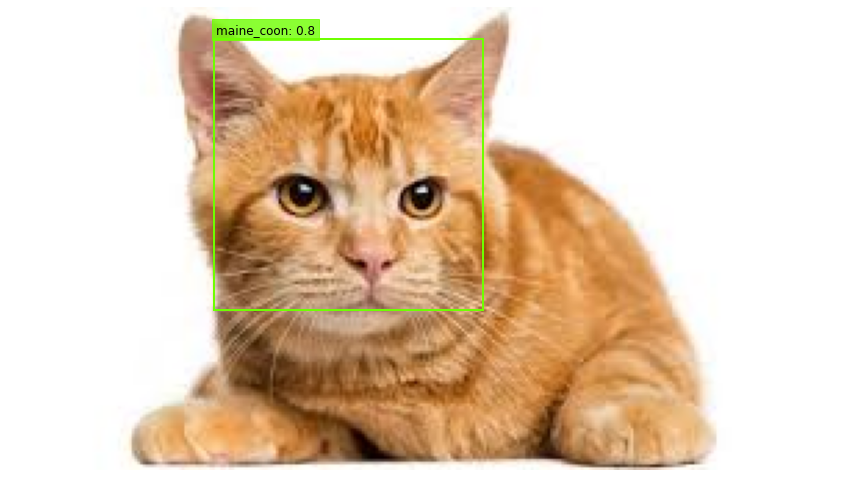

In [83]:
# Inference on User Images
object_detection_api(device=device, score_threshold=0.6, iou_threshold=0.5,)

Saving random_image.jpg to random_image (1).jpg
[INFO] Serializing Model
[INFO] Generating predictions ....
[INFO] Drawing bbox .... 


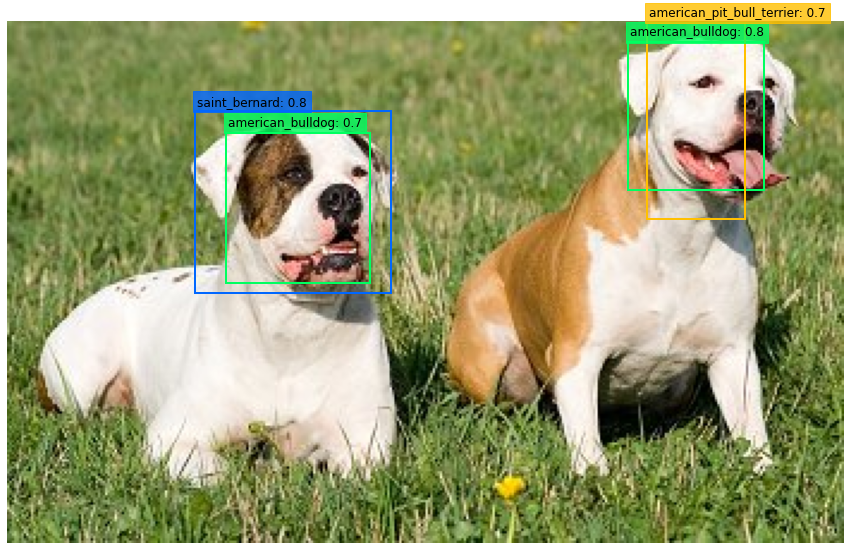

In [85]:
# Inference on User Images
object_detection_api(device=device, score_threshold=0.6, iou_threshold=0.3,)